# Sparse4D Tutorial

- [GitHub](https://github.com/linxuewu/Sparse4D), [Sparse4D v1](https://arxiv.org/abs/2211.10581), [Sparse4D v2](https://arxiv.org/abs/2305.14018), [Sparse4D v3](https://arxiv.org/abs/2311.11722)
 
  

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
cwd = os.getcwd()
if cwd.endswith("tutorial"):
    os.chdir("../")

from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import torch
from mmcv import Config
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmcv.parallel import scatter
from mmcv.cnn.utils.flops_counter import add_flops_counting_methods

from projects.mmdet3d_plugin.datasets.builder import build_dataloader
from projects.mmdet3d_plugin.datasets.utils import draw_lidar_bbox3d

### Base Config

In [2]:
gpu_id = 0
config = "sparse4dv3_temporal_r50_1x8_bs6_256x704"
checkpoint = "ckpt/sparse4dv3_temporal_r50_1x8_bs6_256x704.pth"
cfg = Config.fromfile(f"projects/configs/{config}.py")
# cfg.model["use_deformable_func"] = False
# cfg.model["head"]["deformable_model"]["use_deformable_func"] = False
img_norm_mean = np.array(cfg.img_norm_cfg["mean"])
img_norm_std = np.array(cfg.img_norm_cfg["std"])

### Build Dataloader and Get the Test Data Sample

In [11]:
dataset = build_dataset(cfg.data.val)
dataloader = build_dataloader(
    dataset,
    samples_per_gpu=1,
    workers_per_gpu=0,
    dist=False,
    shuffle=False,
)
data_iter = dataloader.__iter__()
data = next(data_iter)
data = scatter(data, [gpu_id])[0]

{'version': 'v1.0-trainval'}
WARNING!!!!, Only can be used for obtain inference speed!!!!


### Build Model

In [12]:
model = build_detector(cfg.model)
model = model.cuda(gpu_id)
_ = model.load_state_dict(torch.load(checkpoint)["state_dict"], strict=False)
model = model.eval()
# assert model.use_deformable_func, "Please compile deformable aggregation first !!!"

### Anchor Visualization

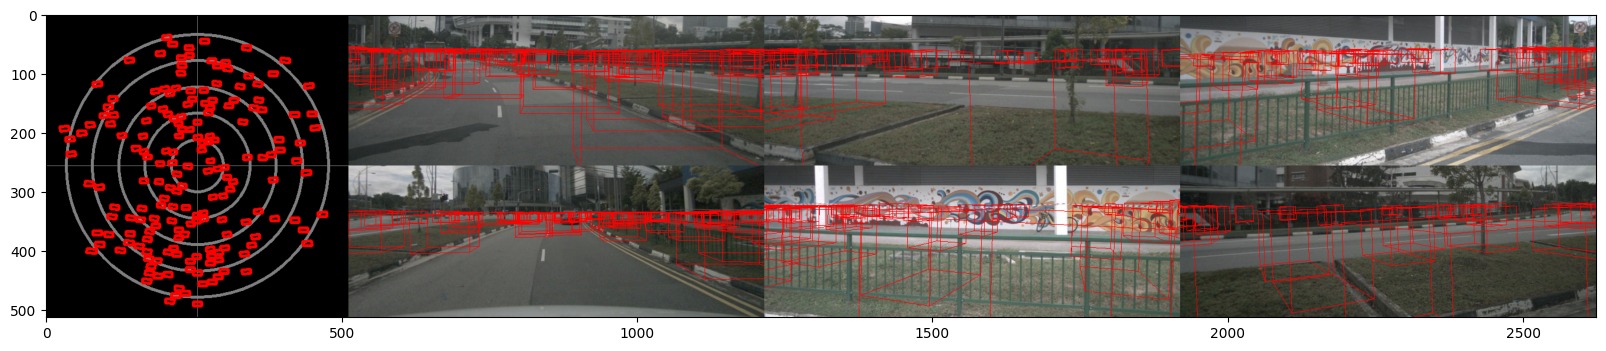

In [13]:
raw_imgs = data["img"][0].permute(0, 2, 3, 1).cpu().numpy()
raw_imgs = raw_imgs * img_norm_std + img_norm_mean

plt.figure(figsize=(20, 10))
anchor = model.head.decoder.decode_box(model.head.instance_bank.anchor)
plt.imshow(
    draw_lidar_bbox3d(anchor[::5], raw_imgs, data["projection_mat"][0])
)

### Forward Image Encoder (Backbone and Neck)

In [14]:
feature_maps = model.extract_feat(data["img"], metas=data)
if model.use_deformable_func:
    print("Feature map format for deformable aggregation: (flatten feature maps, feature size, start inidces).")
    print("Deformable aggregation can accept feature maps from multiple views with different resolutions as input !!!")
    
    print(f"N_camera = {feature_maps[1].shape[0]}")
    print(f"N_scale= {feature_maps[1].shape[1]}\n")
    print(f"Multi-camera multi-scale feature maps, "
        "flatten to shape [batch_size, N_feature, channel]: "
        f"{feature_maps[0].shape}\n"
    )
    print("Deformable aggregation")
    print("Size of all feature maps, [N_camera, N_scale, 2]: ")
    pprint(feature_maps[1].tolist())
    
    print("\nStart indices of all feature maps, [N_camera, N_scale]:")
    pprint(feature_maps[2].tolist())

Feature map format for deformable aggregation: (flatten feature maps, feature size, start inidces).
Deformable aggregation can accept feature maps from multiple views with different resolutions as input !!!
N_camera = 6
N_scale= 4

Multi-camera multi-scale feature maps, flatten to shape [batch_size, N_feature, channel]: torch.Size([1, 89760, 256])

Deformable aggregation
Size of all feature maps, [N_camera, N_scale, 2]: 
[[[64, 176], [32, 88], [16, 44], [8, 22]],
 [[64, 176], [32, 88], [16, 44], [8, 22]],
 [[64, 176], [32, 88], [16, 44], [8, 22]],
 [[64, 176], [32, 88], [16, 44], [8, 22]],
 [[64, 176], [32, 88], [16, 44], [8, 22]],
 [[64, 176], [32, 88], [16, 44], [8, 22]]]

Start indices of all feature maps, [N_camera, N_scale]:
[[0, 11264, 14080, 14784],
 [14960, 26224, 29040, 29744],
 [29920, 41184, 44000, 44704],
 [44880, 56144, 58960, 59664],
 [59840, 71104, 73920, 74624],
 [74800, 86064, 88880, 89584]]


### Forward Sparse4D Decoder Layers

In [15]:
model.head.instance_bank.reset()
model_outs = model.head(feature_maps, data)
print("Output Keys:", model_outs.keys())
print("Number of transformer layers: len(model_outs['classification']).")
print(
    f"Shape of classification is [batch_size, N_instance, N_class] = "
    f"{model_outs['classification'][-1].shape}"
)
print(
    f"Shape of prediction is [batch_size, N_instance, box_dim] = "
    f"{model_outs['prediction'][-1].shape}."
)
if "quality" in model_outs:
    print(
        f"Shape of quality is [batch_size, N_instance, (centerness, yawness)] = "
        f"{model_outs['quality'][-1].shape}."
    )
if "instance_id" in model_outs:
    print(
        f"Shape of instance_id is [batch_size, N_instance] = "
        f"{model_outs['instance_id'].shape}."
    )

Output Keys: dict_keys(['classification', 'prediction', 'quality', 'instance_id'])
Number of transformer layers: len(model_outs['classification']).
Shape of classification is [batch_size, N_instance, N_class] = torch.Size([1, 900, 10])
Shape of prediction is [batch_size, N_instance, box_dim] = torch.Size([1, 900, 11]).
Shape of quality is [batch_size, N_instance, (centerness, yawness)] = torch.Size([1, 900, 2]).
Shape of instance_id is [batch_size, N_instance] = torch.Size([1, 900]).


### Detection Results Visualization

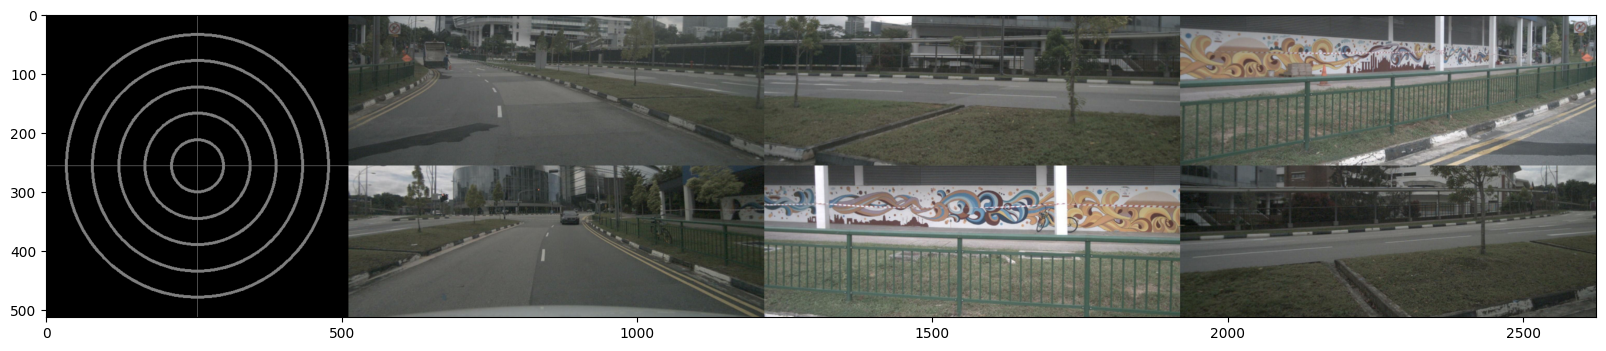

In [16]:
plt.figure(figsize=(20, 10))
pred_bbox3d = model.head.decoder.decode_box(model_outs["prediction"][-1][0])
confidence = model_outs["classification"][-1].max(dim=-1)[0][0].sigmoid()
mask = confidence > 0.35
num_det = mask.sum()
img = draw_lidar_bbox3d(
    torch.cat([pred_bbox3d[mask], anchor[mask]]),
    raw_imgs, data["projection_mat"][0],
    color=[(0, 255, 0)] * num_det + [(255, 0, 0)] * num_det
)
plt.imshow(img)  # The green boxes denotes model detections, and red ones are the corresponding anchors.

### Temporal Instance Visualization

time interval: 0.4999 s.


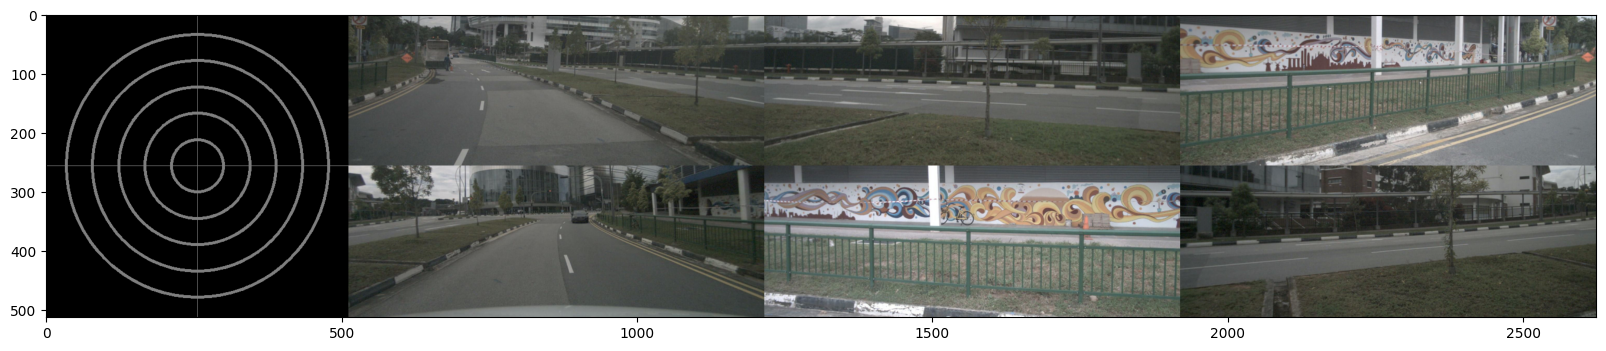

In [17]:
data_next = next(data_iter)
data_next = scatter(data_next, [gpu_id])[0]
raw_imgs_next = data_next["img"][0].permute(0, 2, 3, 1).cpu().numpy()
raw_imgs_next = raw_imgs_next * img_norm_std + img_norm_mean

plt.figure(figsize=(20, 10))
temporal_anchor = model.head.decoder.decode_box(model.head.instance_bank.cached_anchor[0])
print(f"time interval: {(data_next['timestamp'] - data['timestamp']).tolist()[0]:.4f} s.")
mask = model.head.instance_bank.confidence[0] > 0.35
plt.imshow(
    draw_lidar_bbox3d(temporal_anchor[mask], raw_imgs_next, data["projection_mat"][0])
)

### Model Complexity

In [18]:
num_key_pts = (
    cfg.model["head"]["deformable_model"]["kps_generator"]["num_learnable_pts"]
    + len(cfg.model["head"]["deformable_model"]["kps_generator"]["fix_scale"])
)
bilinear_flops = 11
deformable_agg_flops = (
    cfg.num_decoder
    * cfg.embed_dims
    * cfg.num_levels
    * cfg.model["head"]["instance_bank"]["num_anchor"]
    * cfg.model["head"]["deformable_model"]["num_cams"]
    * num_key_pts
    * bilinear_flops
)

for module in ["total", "img_backbone", "img_neck", "head"]:
    if module != "total":
        flops_model = add_flops_counting_methods(getattr(model, module))
    else:
        flops_model = add_flops_counting_methods(model)
    flops_model.eval()
    flops_model.start_flops_count()
    
    if module == "img_backbone":
        flops_model(data["img"].flatten(0, 1))
    elif module == "img_neck":
        flops_model(model.img_backbone(data["img"].flatten(0, 1)))
    elif module == "head":
        flops_model(model.extract_feat(data["img"], metas=data), data)
    else:
        flops_model(**data)
    flops_count, params_count = flops_model.compute_average_flops_cost()
    flops_count *= flops_model.__batch_counter__
    flops_model.stop_flops_count()
    if module == "head" or module == "total":
        flops_count += deformable_agg_flops
    if module == "total":
        total_flops = flops_count
        total_params = params_count
    print(
        f"{module:<13} complexity: "
        f"FLOPs={flops_count/ 10.**9:>8.4f} G / {flops_count/total_flops*100:>6.2f}%, "
        f"Params={params_count/10**6:>8.4f} M / {params_count/total_params*100:>6.2f}%."
    )

total         complexity: FLOPs=168.1413 G / 100.00%, Params= 47.9257 M / 100.00%.
img_backbone  complexity: FLOPs= 88.7854 G /  52.80%, Params= 23.5080 M /  49.05%.
img_neck      complexity: FLOPs= 61.2933 G /  36.45%, Params=  3.3444 M /   6.98%.
head          complexity: FLOPs= 18.0626 G /  10.74%, Params= 21.0725 M /  43.97%.
